# Initialization
In this section the notebook is initialized and usefull constants/functions are defined.

In [1]:
import sys, os, logging
sys.path.append(os.getenv('VIRTUAL_ENV')+'/lib/python3.8/site-packages/')

import curves as c

import matplotlib.pyplot as plt
pc=1e-2
year = 1
month = year/12
day = month/30
week = 7*day

import pandas as pd
pd.set_option('display.max_colwidth', 100)

In [2]:
def curve_build_info(curve):
    '''Show info on the curve'''
    data = []
    for instr in curve.GetInstruments():
        try:
            v1 = instr.Value()
            v2 = instr.Eval(curve)
            data.append({
                'maturity':instr.GetMaturity(),
                'Value':v1,
                'Eval(Curve)':v2,
                'diff':v1-v2,
                'instrument':str(instr)
            })
        except Exception as e:
            logging.error(f'Failed to eval {instr}: {e}')
    df = pd.DataFrame(data)
    df.style.set_caption(f'{curve}')
    return df

# Curve Construction Example
Example of how a curve is constructed.

In [3]:
# Declare a curve variable
curve = c.Curve()

# Add some instruments. We use here only two forward rate agreements.

# FRA, starting at 0 with length 3 months and rate=1%
curve.Add(c.ForwardRateAgreement(0,3*month,0.01))

# FRA, starting at 0 with length 1 year and rate=2%
curve.Add(c.ForwardRateAgreement(0,1*year,0.02))

# Build the curve, cubic spline interpolation is used by default
curve.Build()

# The curve is ready!

value=2.38707e-14 error=nan code=0 error="" x=[-0.00538701,0.0231954,0.00374684,]

## Check
Here we check that the curve instruments are priced correctly.

In [4]:
curve_build_info(curve)

,maturity,Value,Eval(Curve),diff,instrument
0,0.25,0.01,0.01,-8.288771e-08,ForwardRateAgreement start=0 length=0.25 rate=0.01
1,1.00,0.02,0.02,1.303852e-07,ForwardRateAgreement start=0 length=1 rate=0.02


## Plot the Curve

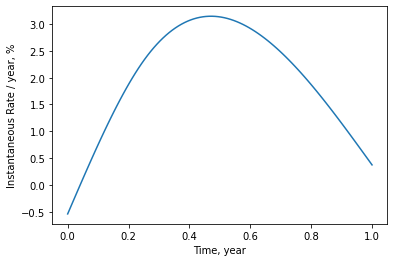

In [5]:
plot_points = 100
fig, ax = plt.subplots()
ax.set_xlabel('Time, year')
ax.set_ylabel('Instantaneous Rate / year, %')
tmax = curve.GetX()[-1]
vx = [(tmax*i)/(plot_points-1) for i in range(plot_points)]
ax.plot(vx,[curve(t)/pc for t in vx])
plt.show()

# Market Quotes
We want to check how the curve is constructed from the real market quotes.
We first need to define a few functions which *adds* instruments to a curve.

In [6]:
def add_eur_libor_quotes_1(curve):
    # https://www.global-rates.com/en/interest-rates/libor/libor.aspx
    
    # date: 06-25-2021
    data = [
        {'t0':0, 'length': 1*day,   'rate': -0.58471*pc},
        {'t0':0, 'length': 1*week,  'rate': -0.57571*pc},
        {'t0':0, 'length': 1*month, 'rate': -0.57786*pc},
        {'t0':0, 'length': 2*month, 'rate': -0.55857*pc},
        {'t0':0, 'length': 3*month, 'rate': -0.54614*pc},
        {'t0':0, 'length': 6*month, 'rate': -0.52614*pc},
        {'t0':0, 'length': 1*year,  'rate': -0.48357*pc},
    ]
    for v in data:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [7]:
def add_eur_libor_quotes_2(curve):
    # https://www.chathamfinancial.com/technology/european-market-rates
    
    # date: 06-25-2021
    data = [
        {'t0':0, 'length': 1*month, 'rate': -0.56200*pc},
        {'t0':0, 'length': 3*month, 'rate': -0.53800*pc},
        {'t0':0, 'length': 6*month, 'rate': -0.51300*pc},
        {'t0':0, 'length': 1*year,  'rate': -0.47800*pc},
    ]
    for v in data:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [8]:
def add_swaps(curve,curve_float_leg=None):
    if curve_float_leg is None:
        curve_float_leg = curve
    t0 = 0
    dt = year*0.25
    swaps = {
         1*year:  0.19*pc,
         2*year:  0.32*pc,
         3*year:  0.55*pc,
         5*year:  0.93*pc,
         7*year:  1.20*pc,
        10*year:  1.45*pc,
        15*year:  1.53*pc,
        30*year:  1.78*pc
    }
    for period,rate in swaps.items():

        swap = c.Swap()

        # fixed rate: payed quartely
        swap.lfix = c.LegFixed(t0,dt,round(period/dt),rate)

        # floating rate: payed quartely
        dt = year*0.25

        swap.lflt = c.LegFloat(t0,dt,round(period/dt),curve_float_leg)
        curve.Add(swap)

# Curve Interpolation

There are several choices available to interpolate the curve. The most reasonable interpolations 
are:
- piecewise constant
- linear
- cubic spline

We show that using different interpolations we are able to price the instruments correctly, though the curve shape changes dramatically from one interpolation type to another.

In [9]:
def f(add_data,interpolations,plot_points=1000):
    curves = {}
    build_info = {}
    tmax = None

    for itype in interpolations:
        curve = c.Curve()
        curves[itype] = curve
        try:
            add_data(curve)
            curve.Build(itype)
            tmax = curve.GetX()[-1]
        except Exception as e:
            logging.error(f'Problem with {itype} interpolation: {e}')
        build_info[itype] = curve_build_info(curve)

    if tmax:
        vx = [(tmax*i)/(plot_points-1) for i in range(plot_points)]
        def line_style(i):
            l = ['-',':','--','-.']
            return l [i%len(l)]

        fig1, ax1 = plt.subplots()
        ax1.set_xlabel('Time, year')
        ax1.set_ylabel('Instantaneous Rate / year, %')

        fig2, ax2 = plt.subplots()
        ax2.set_xlabel('Time, year')
        ax2.set_ylabel('Forward Rate / year, %')
        
        i=0
        for itype,curve in curves.items():
            ax1.plot(
                vx,
                [curve(t)/pc for t in vx],
                label=str(itype),
                linestyle=line_style(i)
            )
            ax2.plot(
                vx,
                [curve.GetForwardRate(0,t)/pc for t in vx],
                label=str(itype),
                linestyle=line_style(i)
            )
            i += 1
#        loc = 'upper bottom'
#        ax1.legend(loc=loc, shadow=True)
#        ax2.legend(loc=loc, shadow=True)
        ax1.legend(shadow=True)
        ax2.legend(shadow=True)

    return {
        'curves':curves,
        'build_info':build_info,
        'plots' :{
            'InstantaneousRates': fig1,
            'ForwardRates': fig2,
        }
    }

In [10]:
interpolations = [
    c.Interpolator1D.Type.PiecewiseConstant,
    c.Interpolator1D.Type.Linear,
    c.Interpolator1D.Type.CubicSpline,
#    c.Interpolator1D.Type.Akima,
   c.Interpolator1D.Type.Steffen
]

## Building with FRAs (data1)

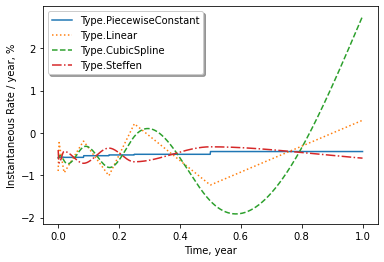

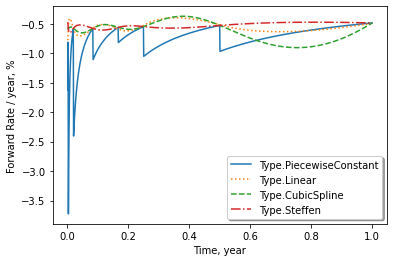

In [11]:
r = f(add_eur_libor_quotes_1,interpolations)

In [12]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005836,-1.066085e-05,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.005756,-6.356277e-07,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005779,7.050112e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.005586,-7.916242e-09,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.005461,-9.918585e-08,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005261,8.847564e-09,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004836,-3.725290e-09,ForwardRateAgreement start=0 length=1 rate=-0.0048357


In [13]:
r['build_info'][c.Interpolator1D.Type.Linear]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005622,-0.000225,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.005793,0.000036,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005719,-0.000059,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.005877,0.000291,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.005248,-0.000213,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005165,-0.000096,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004921,0.000085,ForwardRateAgreement start=0 length=1 rate=-0.0048357


In [14]:
r['build_info'][c.Interpolator1D.Type.CubicSpline]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005836,-1.066085e-05,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.005763,5.494338e-06,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005779,7.050112e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.005586,-7.916242e-09,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.005460,-1.527835e-06,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005260,-1.179986e-06,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004836,1.150183e-07,ForwardRateAgreement start=0 length=1 rate=-0.0048357


In [15]:
r['build_info'][c.Interpolator1D.Type.Steffen]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005836,-1.066085e-05,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.005756,-6.356277e-07,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005778,-7.250346e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.005586,-7.916242e-09,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.005462,3.771856e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005261,-2.291054e-07,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004835,-2.407469e-07,ForwardRateAgreement start=0 length=1 rate=-0.0048357


## Building with FRAs (data2)

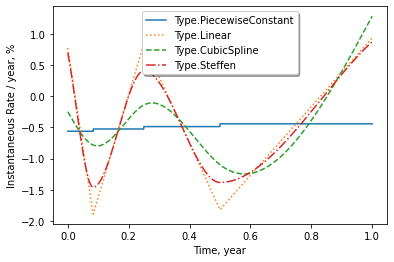

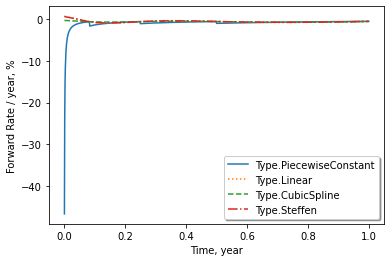

In [16]:
r = f(add_eur_libor_quotes_2,interpolations)

In [17]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005621,5.932525e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005380,-1.280569e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005130,-9.452924e-08,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004780,5.541369e-08,ForwardRateAgreement start=0 length=1 rate=-0.00478


In [18]:
r['build_info'][c.Interpolator1D.Type.Linear]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005619,-8.363277e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005379,-6.039627e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005131,6.188639e-07,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004780,-3.003515e-07,ForwardRateAgreement start=0 length=1 rate=-0.00478


In [19]:
r['build_info'][c.Interpolator1D.Type.CubicSpline]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005619,-8.363277e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005381,8.242205e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005129,-1.283828e-06,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004781,6.486662e-07,ForwardRateAgreement start=0 length=1 rate=-0.00478


In [20]:
r['build_info'][c.Interpolator1D.Type.Steffen]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005619,-8.363277e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005379,-6.039627e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005131,6.188639e-07,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004780,-1.820736e-07,ForwardRateAgreement start=0 length=1 rate=-0.00478


## Building with SWAPs

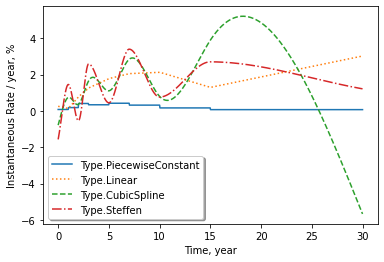

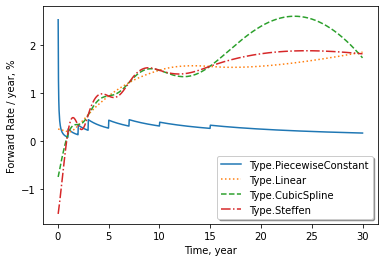

In [21]:
r = f(add_swaps,interpolations)

In [22]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,1.164153e-10,-1.164153e-10,Swap: (LegFixed t0=0 dt=0.25 n=4 rate=0.0019) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,0.000000e+00,0.000000e+00,Swap: (LegFixed t0=0 dt=0.25 n=8 rate=0.0032) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,1.862645e-09,-1.862645e-09,Swap: (LegFixed t0=0 dt=0.25 n=12 rate=0.0055) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,-3.725290e-09,3.725290e-09,Swap: (LegFixed t0=0 dt=0.25 n=20 rate=0.0093) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,0.000000e+00,0.000000e+00,Swap: (LegFixed t0=0 dt=0.25 n=28 rate=0.012) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,1.490116e-08,-1.490116e-08,Swap: (LegFixed t0=0 dt=0.25 n=40 rate=0.0145) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,0.000000e+00,0.000000e+00,Swap: (LegFixed t0=0 dt=0.25 n=60 rate=0.0153) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,-1.192093e-07,1.192093e-07,Swap: (LegFixed t0=0 dt=0.25 n=120 rate=0.0178) (LegFloat t0=0 dt=0.25 n=120)


In [23]:
r['build_info'][c.Interpolator1D.Type.Linear]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,-3.341120e-07,3.341120e-07,Swap: (LegFixed t0=0 dt=0.25 n=4 rate=0.0019) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,1.018401e-06,-1.018401e-06,Swap: (LegFixed t0=0 dt=0.25 n=8 rate=0.0032) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,-1.456589e-06,1.456589e-06,Swap: (LegFixed t0=0 dt=0.25 n=12 rate=0.0055) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,-5.029142e-07,5.029142e-07,Swap: (LegFixed t0=0 dt=0.25 n=20 rate=0.0093) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,1.490116e-08,-1.490116e-08,Swap: (LegFixed t0=0 dt=0.25 n=28 rate=0.012) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,8.791685e-07,-8.791685e-07,Swap: (LegFixed t0=0 dt=0.25 n=40 rate=0.0145) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,-2.533197e-07,2.533197e-07,Swap: (LegFixed t0=0 dt=0.25 n=60 rate=0.0153) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,-1.490116e-07,1.490116e-07,Swap: (LegFixed t0=0 dt=0.25 n=120 rate=0.0178) (LegFloat t0=0 dt=0.25 n=120)


In [24]:
r['build_info'][c.Interpolator1D.Type.CubicSpline]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,0.000489,-0.000489,Swap: (LegFixed t0=0 dt=0.25 n=4 rate=0.0019) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,-0.000404,0.000404,Swap: (LegFixed t0=0 dt=0.25 n=8 rate=0.0032) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,0.000224,-0.000224,Swap: (LegFixed t0=0 dt=0.25 n=12 rate=0.0055) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,-0.000108,0.000108,Swap: (LegFixed t0=0 dt=0.25 n=20 rate=0.0093) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,0.000076,-0.000076,Swap: (LegFixed t0=0 dt=0.25 n=28 rate=0.012) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,-0.000021,0.000021,Swap: (LegFixed t0=0 dt=0.25 n=40 rate=0.0145) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,-0.000003,0.000003,Swap: (LegFixed t0=0 dt=0.25 n=60 rate=0.0153) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,0.000002,-0.000002,Swap: (LegFixed t0=0 dt=0.25 n=120 rate=0.0178) (LegFloat t0=0 dt=0.25 n=120)


In [25]:
r['build_info'][c.Interpolator1D.Type.Steffen]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,-3.253808e-07,3.253808e-07,Swap: (LegFixed t0=0 dt=0.25 n=4 rate=0.0019) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,-4.256144e-07,4.256144e-07,Swap: (LegFixed t0=0 dt=0.25 n=8 rate=0.0032) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,-2.793968e-07,2.793968e-07,Swap: (LegFixed t0=0 dt=0.25 n=12 rate=0.0055) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,6.332994e-07,-6.332994e-07,Swap: (LegFixed t0=0 dt=0.25 n=20 rate=0.0093) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,4.917383e-07,-4.917383e-07,Swap: (LegFixed t0=0 dt=0.25 n=28 rate=0.012) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,2.831221e-07,-2.831221e-07,Swap: (LegFixed t0=0 dt=0.25 n=40 rate=0.0145) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,1.072884e-06,-1.072884e-06,Swap: (LegFixed t0=0 dt=0.25 n=60 rate=0.0153) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,2.384186e-07,-2.384186e-07,Swap: (LegFixed t0=0 dt=0.25 n=120 rate=0.0178) (LegFloat t0=0 dt=0.25 n=120)


# Using Many real quotes

In [36]:
true=True
real_quotes = [{"type":"FRA","use":true,"start":0,"length":1,"quote":-0.371},{"type":"FRA","use":true,"start":0,"length":2,"quote":-0.341},{"type":"FRA","use":true,"start":0,"length":3,"quote":-0.329},{"type":"FRA","use":true,"start":0,"length":6,"quote":-0.278},{"type":"FRA","use":true,"start":0,"length":9,"quote":-0.222},{"type":"FRA","use":true,"start":0,"length":12,"quote":-0.191},{"type":"FRA","use":true,"start":1,"length":12},{"type":"FRA","use":true,"start":1,"length":13,"quote":-0.188},{"type":"FRA","use":true,"start":2,"length":5,"quote":-0.322},{"type":"FRA","use":true,"start":2,"length":14,"quote":-0.174},{"type":"FRA","use":true,"start":3,"length":6,"quote":-0.32},{"type":"FRA","use":true,"start":3,"length":15,"quote":-0.158},{"type":"FRA","use":true,"start":5,"length":17,"quote":-0.117},{"type":"FRA","use":true,"start":6,"length":9,"quote":-0.311},{"type":"FRA","use":true,"start":6,"length":18,"quote":-0.091},{"type":"FRA","use":true,"start":7,"length":13,"quote":-0.236},{"type":"FRA","use":true,"start":9,"length":21,"quote":-0.033},{"type":"FRA","use":true,"start":11,"length":14,"quote":-0.245},{"type":"FRA","use":true,"start":11,"length":17,"quote":-0.142},{"type":"FRA","use":true,"start":12,"length":12},{"type":"FRA","use":true,"start":12,"length":18},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":12,"quote":-0.2645},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":24,"quote":-0.124},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":36,"quote":0.088},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":48,"quote":0.293},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":60,"quote":0.484},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":72,"quote":0.648},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":84,"quote":0.79},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":96,"quote":0.915},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":108,"quote":1.025},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":120,"quote":1.123},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":156,"quote":1.341},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":168,"quote":1.394},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":180,"quote":1.441},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":240,"quote":1.573},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":360,"quote":1.615},{"type":"Swap","use":true,"leg1":12,"leg2":6,"length":720,"quote":1.54}]

In [37]:
import math
def add_data(curve,data):
    for v in data:
        if not v.get('use'): continue
        if math.isnan(v.get('quote',math.nan)): continue
        if v['type']=='FRA':
            curve.Add(c.ForwardRateAgreement(v['start'],v['length'],v['quote']))
        elif v['type']=='Swap':
            swap = c.Swap()
            t0     = 0
            dt     = v['leg2']/12.
            length = v['length']
            rate   = v['quote']
            swap.lfix = c.LegFixed(t0,dt,round(length/dt),rate)
            swap.lflt = c.LegFloat(t0,dt,round(length/dt),curve)
        else:
            print('ignoring',v['type'])
def add_real_quotes(curve):
    return add_data(curve,real_quotes)

In [38]:
curve = c.Curve()
add_data(curve,real_quotes)
curve.Build()

value=0.00663584 error=nan code=0 error="" x=[-0.993713,0.000631225,-0.613147,0.0646942,-0.6533,0.142713,-1.14281,1.34157,-1.89739,-1.19814,2.99527,-3.36287,2.13964,-1.20079,-0.298279,-4.86046,6.25083,-6.82113,]

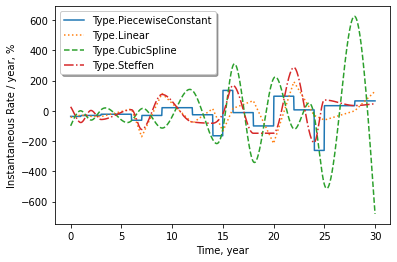

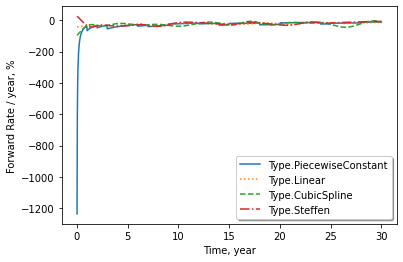

In [39]:
r = f(add_real_quotes,interpolations)

In [40]:
r['build_info'][c.Interpolator1D.Type.Steffen]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,-0.371,-0.341483,-0.029517,ForwardRateAgreement start=0 length=1 rate=-0.371
1,2.0,-0.341,-0.358810,0.017810,ForwardRateAgreement start=0 length=2 rate=-0.341
2,3.0,-0.329,-0.331343,0.002343,ForwardRateAgreement start=0 length=3 rate=-0.329
3,6.0,-0.278,-0.292166,0.014166,ForwardRateAgreement start=0 length=6 rate=-0.278
4,7.0,-0.322,-0.323617,0.001617,ForwardRateAgreement start=2 length=5 rate=-0.322
5,9.0,-0.320,-0.249288,-0.070712,ForwardRateAgreement start=3 length=6 rate=-0.32
6,12.0,-0.191,-0.159825,-0.031175,ForwardRateAgreement start=0 length=12 rate=-0.191
7,14.0,-0.188,-0.243612,0.055612,ForwardRateAgreement start=1 length=13 rate=-0.188
8,15.0,-0.311,-0.263313,-0.047687,ForwardRateAgreement start=6 length=9 rate=-0.311
9,16.0,-0.174,-0.183059,0.009059,ForwardRateAgreement start=2 length=14 rate=-0.174


In [43]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,-0.371,-0.371,2.980232e-08,ForwardRateAgreement start=0 length=1 rate=-0.371
1,2.0,-0.341,-0.341,0.000000e+00,ForwardRateAgreement start=0 length=2 rate=-0.341
2,3.0,-0.329,-0.329,2.980232e-08,ForwardRateAgreement start=0 length=3 rate=-0.329
3,6.0,-0.278,-0.278,0.000000e+00,ForwardRateAgreement start=0 length=6 rate=-0.278
4,7.0,-0.322,-0.322,0.000000e+00,ForwardRateAgreement start=2 length=5 rate=-0.322
5,9.0,-0.320,-0.320,-2.980232e-08,ForwardRateAgreement start=3 length=6 rate=-0.32
6,12.0,-0.191,-0.191,0.000000e+00,ForwardRateAgreement start=0 length=12 rate=-0.191
7,14.0,-0.188,-0.188,0.000000e+00,ForwardRateAgreement start=1 length=13 rate=-0.188
8,15.0,-0.311,-0.311,0.000000e+00,ForwardRateAgreement start=6 length=9 rate=-0.311
9,16.0,-0.174,-0.174,0.000000e+00,ForwardRateAgreement start=2 length=14 rate=-0.174
